# Logistic Regression: Determine Crack Presence

# Step 0: Install Packages and Declare Functions

In [1]:
#Install packages
!pip install numpy 
!pip install pandas 
!pip install sklearn
!pip install --upgrade pip
!pip install opencv-python

#Import libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from random import sample, randint, shuffle
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# image operation
import cv2
from PIL import Image
from scipy.ndimage import median_filter
from scipy import ndimage

import os
import shutil
import pandas as pd
import numpy as np

Requirement already up-to-date: pip in /anaconda3/lib/python3.6/site-packages (18.1)


In [7]:
#define all used functions

# function for loading, resizing and converting an image into greyscale
#flattening converts the image to a numpy array, populated by the brightness of each pixel
#resize image to 64x64 for processing
def img_to_1d_greyscale(img_path, size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return(pd.Series(img.flatten()))

# function for moving random files from one directory to another (used for creating train and test set)
def move_random_files(path_from, path_to, n):
    files = os.listdir(path_from)
    files.sort()
    files = files[1:] #omiting .DS_Store

    for i in sample(range(0, len(files)-1), n):
        f = files[i]
        src = path_from + f
        dst = path_to + f
        shutil.move(src, dst)

# function for getting correctly and incorrectly classified indices
def evaluation_indices(y_pred, y_test):
    index = 0
    correctly_classified_indices = []
    misclassified_indices = []
    for label, predict in zip(y_test, y_pred):
        if label != predict: 
            misclassified_indices.append(index)
        else:
            correctly_classified_indices.append(index)
        index +=1
    return (correctly_classified_indices, misclassified_indices)

# function for viewing an image
def show_image(image):
    fig = plt.figure(figsize = (5, 25))
    ax = fig.add_subplot(111)
    ax.imshow(image, interpolation='none')
    plt.show()
    

# function for previewing a random image from a given directory
def preview_random_image(path):
    files = os.listdir(path)
    files.sort()
    img_name = files[randint(1, len(files) - 1)]
    img_preview_name = path + img_name
    image = Image.open(img_preview_name)
    plt.imshow(image)
    plt.title(img_name)
    plt.show()
    width, height = image.size
    print ("Dimensions:", image.size, "Total pixels:", width * height)
    
 # implementation of a confusion matrix
def pretty_cm(y_pred, y_truth, labels):
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

# Step 1: Data Preprocessing - split data to test and train set

Although we have accesss to 40,000 images, run example on smaller set. Aim for 80-20 split . Want to have a training set of 4,000 images, and a test set of 1,000 images for each categorization. Total number of images used in this example will be 10,000 images

In [12]:
#This code randomly splits the images into different folders
#The data files submitted with the report are already sorted
#Thus this cell has been entirely commented out

#split data into test set, crack

#move_random_files(path_from = 'Crack/', 
#                  path_to = 'test_set/crack/', 
#                  n = 1000)
#train set, crack
#move_random_files(path_from = 'Crack/', 
#                  path_to = 'train_set/crack/', 
#                  n = 4000)

#test set, no_crack
#move_random_files(path_from = 'No_Crack/', 
#                  path_to = 'test_set/no_crack/', 
#                  n = 1000)

#train set, no_crack
#move_random_files(path_from = 'No_Crack/', 
#                  path_to = 'train_set/no_crack/', 
#                  n = 4000)

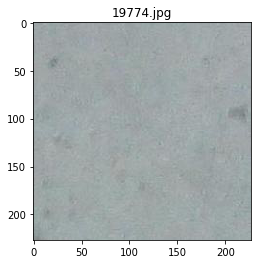

Dimensions: (227, 227) Total pixels: 51529


In [36]:
#preview random image
preview_random_image('train_set/no_crack/')

# Step 2: Organize Images into Test and Train Data Sets

In [3]:
#create a space to store information about the test and training set data

size = (64, 64)

# defining empty containers. will keep data in terms of pixels and observation value (0= crack, 1 = no crack)
X_train = pd.DataFrame(np.zeros((8000, size[0] * size[1])))
X_test = pd.DataFrame(np.zeros((2000, size[0] * size[1])))
y_train = list()
y_test = list()

In [4]:
# iterating through files to load information to empty data containers. Create training and test set, 
#(0= crack, 1 = no crack)

counter_train = 0
counter_test = 0

# training set 

files = os.listdir('train_set/crack')
files.sort()

# add conversion to greyscale to train set, 0 to y b/c crack is present

for i in range(0, len(files)):
    X_train.iloc[counter_train, :] = img_to_1d_greyscale('train_set/crack/' + files[i], size) / 255
    y_train.append(0)
    counter_train += 1
    
files = os.listdir('train_set/no_crack')
files.sort()

# add conversion to greyscale to train set, 1 to y b/c no crack is present

for i in range(0, len(files)):
    X_train.iloc[counter_train, :] = img_to_1d_greyscale('train_set/no_crack/' + files[i], size) / 255
    y_train.append(1)
    counter_train += 1
   

#test set

files = os.listdir('test_set/crack')
files.sort()

# add conversion to greyscale to test set, 0 to y b/c crack is present

for i in range(0, len(files)):
    X_test.iloc[counter_test, :] = img_to_1d_greyscale('test_set/crack/' + files[i], size) / 255
    y_test.append(0)
    counter_test += 1
    
files = os.listdir('test_set/no_crack')
files.sort()
# add conversion to greyscale to test set, 1 to y b/c no crack is present

for i in range(0, len(files)):
    X_test.iloc[counter_test, :] = img_to_1d_greyscale('test_set/no_crack/' + files[i], size) / 255
    y_test.append(1)  
    counter_test += 1

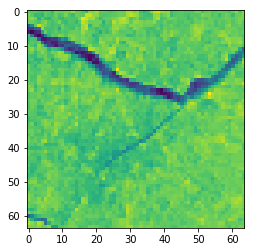

In [5]:
# example image from training set, am image with a crack
plt.imshow(np.reshape(X_train.iloc[2000, ].values, size))

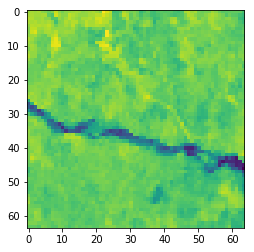

In [6]:
# example image from test set, am image with a crack
plt.imshow(np.reshape(X_test.iloc[0, ].values, size))

In [7]:
#look at the train set dataframe
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.552941,0.568627,0.560784,0.568627,0.564706,0.572549,0.576471,0.584314,0.580392,0.592157,...,0.592157,0.584314,0.596078,0.580392,0.588235,0.580392,0.588235,0.580392,0.588235,0.572549
1,0.627451,0.623529,0.611765,0.627451,0.631373,0.623529,0.619608,0.627451,0.615686,0.611765,...,0.635294,0.631373,0.623529,0.619608,0.631373,0.611765,0.619608,0.623529,0.631373,0.631373
2,0.631373,0.654902,0.647059,0.631373,0.627451,0.650980,0.686275,0.682353,0.643137,0.674510,...,0.584314,0.580392,0.588235,0.576471,0.596078,0.584314,0.580392,0.588235,0.576471,0.588235
3,0.596078,0.603922,0.603922,0.611765,0.607843,0.615686,0.611765,0.627451,0.596078,0.592157,...,0.592157,0.588235,0.576471,0.580392,0.572549,0.600000,0.596078,0.588235,0.596078,0.600000
4,0.600000,0.600000,0.596078,0.600000,0.596078,0.615686,0.600000,0.576471,0.596078,0.584314,...,0.560784,0.564706,0.564706,0.568627,0.580392,0.580392,0.568627,0.541176,0.552941,0.576471


As we can see from the dataframe above, each row represents a single image, and each column represents a single pixel. The image is of size 64x64, so there are 4096 pixels per image. the value in each column represents the brightness of each pixel, 0 = black, 1 = white. The train and test sets are both built according to this procedure.

# Step 3: Analyze Data

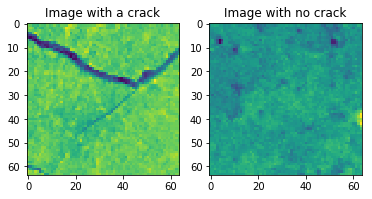

In [22]:
#plot the pixel and brightness of an image with a craack versus an image without a crack
#first, select two images (one with a crack, one without a crack)

f = plt.figure()
ax1 = f.add_subplot(1,2, 1)

#image with a crack
plt.imshow(np.reshape(X_train.iloc[2000, ].values, size))
ax1.title.set_text('Image with a crack')

ax2 = f.add_subplot(1,2, 2)
#image with no crack
plt.imshow(np.reshape(X_train.iloc[5000, ].values, size))
ax2.title.set_text('Image with no crack')

plt.show(block=True)

Text(0.5,1,'Pixel Values for Image with a Crack and Image Without a Crack')

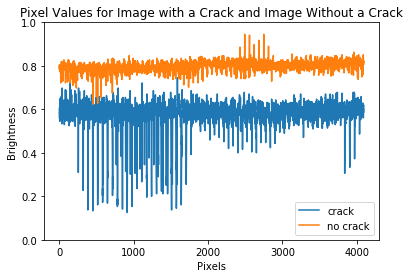

In [32]:
crack = X_train.iloc[2000, ].values
crack
no_crack = X_train.iloc[5000, ].values
no_crack

#plot the crack and no crack lines

plt.plot(crack, label = 'crack')
plt.plot(no_crack, label = 'no crack')
plt.legend()
plt.xlabel("Pixels")
plt.ylabel("Brightness")
plt.ylim(0,1)
plt.title('Pixel Values for Image with a Crack and Image Without a Crack')

As we can see from the example above, images with a crack lack have occurances where a lack in consistent pixel brightness occurs, indicating that a crack is present.


# Step 4: Train the model

In [41]:
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Step 5: Test Model

In [42]:
logreg_pred = logreg_classifier.predict(X_test)

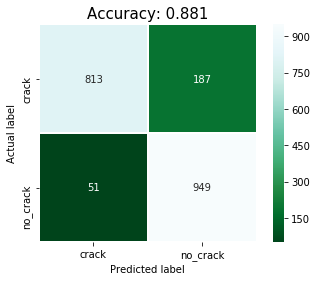

In [44]:
pretty_cm(logreg_pred, y_test, ['crack', 'no_crack'])

# Step 6: Hyperparameter Tuning to Improve Logistic Regression Model

This accuracy score, of 88.5% occured with a C value of 1.0. The next step would be to test a variety of C values to improve the accuracy of the model.

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve

C_param_range = [0.001,0.01,0.1,1,10,100]

acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
acc_table['C_parameter'] = C_param_range

#plt.figure(figsize=(10, 10))

j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    lr = LogisticRegression(penalty = 'l2', C = i,random_state = 0)
    lr.fit(X_train,y_train)
    
    # Predict using model
    y_pred_i = lr.predict(X_test)
    
    # Saving accuracy score in table
    acc_table.iloc[j,1] = accuracy_score(y_test,y_pred_i)
    j += 1
    
acc_table

,C_parameter,Accuracy
0,0.001,0.862
1,0.010,0.8905
2,0.100,0.8915
3,1.000,0.881
4,10.000,0.866
5,100.000,0.8565


In [46]:
#plot validation curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve
### 1. Use of validation curves for both datasets.
C_param_range = [0.001,0.01,0.1,1,10, 100, 1000]



X_combined_standard = np.vstack((X_train, X_test))
Y_combined = np.hstack((y_train,y_test))

# Apply logistic regression model to training data
lr = LogisticRegression(penalty='l2',C = i,random_state = 0)

# SEPAL Plot validation curve
train_scores, test_scores = validation_curve(estimator=lr
                                                            ,X=X_combined_standard
                                                            ,y=Y_combined
                                                            ,param_name='C'
                                                            ,param_range=C_param_range
                                                            )

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)




(0.5, 1)

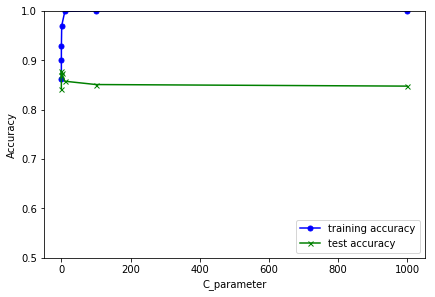

In [47]:
#plot accuracy as 
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.plot(C_param_range
            ,train_mean
            ,color='blue'
            ,marker='o'
            ,markersize=5
            ,label='training accuracy')
    
plt.plot(C_param_range
            ,test_mean
            ,color='green'
            ,marker='x'
            ,markersize=5
            ,label='test accuracy') 
    
plt.xlabel('C_parameter')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5,1])


As is evident, we can improve the accuracy by ~2% when we set the C parameter around 0.1.
Plot test and train performance as we toggle C. Set highest value of c to 1, to better udnerstand where C is optimized.

Text(0.5,1,'Accuracy for Test and Training Set')

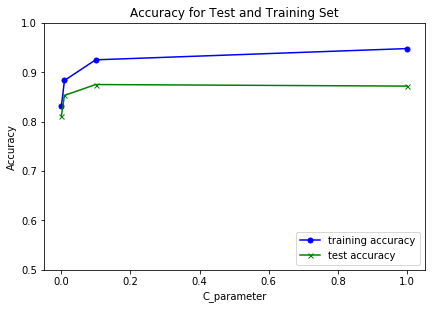

In [48]:
### 1. Use of validation curves for both datasets.
C_param_range = [0.001,0.01,0.1,1]

# Apply logistic regression model to training data
lr = LogisticRegression(penalty='l2',C = i,random_state = 0, solver ='lbfgs' )

# SEPAL Plot validation curve
train_scores, test_scores = validation_curve(estimator=lr
                                                            ,X=X_combined_standard
                                                            ,y=Y_combined
                                                            ,param_name='C'
                                                            ,param_range=C_param_range
                                                            )

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

#plot accuracy as 
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.plot(C_param_range
            ,train_mean
            ,color='blue'
            ,marker='o'
            ,markersize=5
            ,label='training accuracy')
    
plt.plot(C_param_range
            ,test_mean
            ,color='green'
            ,marker='x'
            ,markersize=5
            ,label='test accuracy') 
    
plt.xlabel('C_parameter')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5,1])
plt.title('Accuracy for Test and Training Set')



It is evident that the accuracy for C is optimized when C = 0.1.
Perform linear regression where C = 0.1, show results in a confusion matrix, as well as a classification report.

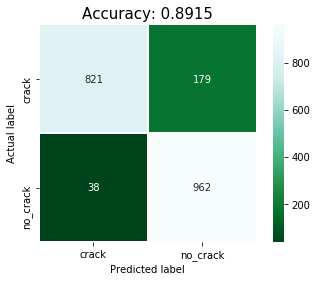

In [8]:
lr = LogisticRegression(penalty = 'l2', C = 0.1,random_state = 0 )
lr.fit(X_train,y_train)
    
# Predict using model
y_pred_i_classifier = lr.predict(X_test)

pretty_cm(y_pred_i_classifier, y_test, ['crack', 'no_crack'])


Build the results summary table to better understand why the model is not predicting perfectly.

# Step 7: Investigation of Results

In [30]:
Test_Results = pd.DataFrame({'Predicted_Value':y_pred_i_classifier, 'True_Value':y_test})

In [33]:
Test_Results

,Predicted_Value,True_Value
0,0,0
1,1,0
2,1,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


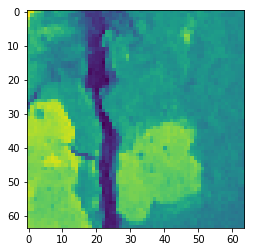

In [34]:
#look at some examples of the images to try to understand why some were mis-predeicted
#image 13 is the test set was predicted to have no crack, but in reality has a crack
plt.imshow(np.reshape(X_test.iloc[13, ].values, size))


Text(0.5,1,'Pixel Values for Image 13 of the Test Set, Mis-Predicted')

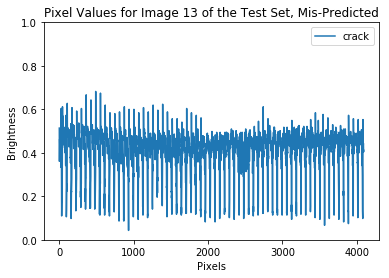

In [35]:
#plot the graoh of image 13 brightness of pixels
crack = X_train.iloc[13, ].values



#plot the crack and no crack lines

plt.plot(crack, label = 'crack')
plt.legend()
plt.xlabel("Pixels")
plt.ylabel("Brightness")
plt.ylim(0,1)
plt.title('Pixel Values for Image 13 of the Test Set, Mis-Predicted')

As is evident from this image of the pixel birghtness, there is no apparent section that would indicate a crack is present (as we saw in the image above when there was a clear bulge (decrease in brightness for a subset of sequential pixel values) that would indicate a crack is present. 

# Crack Classification

# Step 0: Preliminary Stages

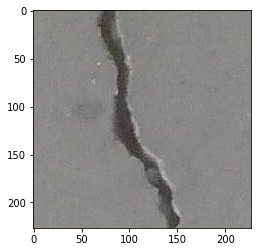

In [3]:
#Open and Preview Image
image = cv2.imread('00001.jpg',1)
plt.imshow(image)

# Step 1: Image Processing

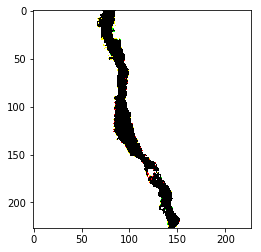

In [4]:
#Thresholding the image 
#Lower the '100' for bigger cracks, Increase for smaller cracks 
ret,image2 = cv2.threshold(image,100,255,cv2.THRESH_BINARY) 
plt.imshow(image2)

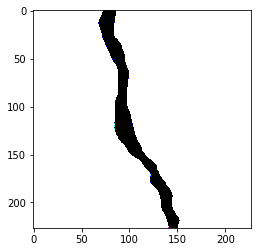

In [5]:
#Eliminate noise/Erode, and blur image
image3 = ndimage.median_filter(image2, 10)
plt.imshow(image3)

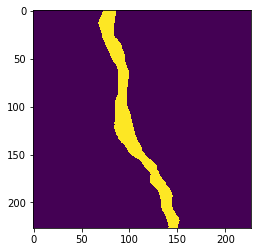

In [6]:
#Convert image to grayscale then the values to binary
image4 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
image4 = image4!=255
image5 = image4.astype(int)
plt.imshow(image5)

# Step 2: Extracting Data

In [7]:
#Calculate the area coverage that corresponds to the crack
NumberofRows = np.size(image5,0)
CrackPixels = sum([sum(image5[i]) for i in range(NumberofRows)])
TotalPixels   = image.shape[0] * image.shape[1]
CrackPercentage = CrackPixels / TotalPixels
CrackPercentage = 100*CrackPercentage
print (CrackPercentage,'%', ' Crack Coverage')

6.163519571503425 %  Crack Coverage


In [8]:
#Calculate the width of the crack

#Vertical Crack
NumberofRows = np.size(image5,0)
VSum = [sum(image5[i]) for i in range(NumberofRows)]
VAverage = sum(VSum)/len(VSum)
VStd = np.std(VSum)

#Horizontal Crack
NumberofColumns = np.size(image2,1)
HSum = [sum(x) for x in zip(*image5)]
HAverage = sum(HSum)/len(HSum)
HStd = np.std(HSum)

#Printing results and categorizing the crack as primarily vertical or horizontal
if VStd < HStd:
    print('Vertical Crack')
    print(VAverage, '+/-', VStd, 'pixels')
else:
    print('Horizontal Crack')
    print (HAverage, '+/-', HStd, 'pixels')

Vertical Crack
13.991189427312776 +/- 2.733365693165743 pixels
